## Uber Ride Price Prediction

### Problem Description

The objective of this project is to develop a Machine Learning model capable of predicting the price of Uber rides based on several factors, such as distance, time, weather conditions, type of service, among others. Accurate forecasts can help both passengers and drivers better understand the costs involved and optimize service supply and demand.

### Objective

Build a predictive model that estimates the price of an Uber ride, using regression techniques and advanced hyperparameter tuning approaches.

In [98]:
import sys
print(f"Running with Python located at: {sys.executable}")

Running with Python located at: /usr/local/python/3.12.1/bin/python3


In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import time
import os

import folium
from folium.plugins import HeatMap

from sklearn.feature_selection import RFE

### Data Collection and Preparation

In [100]:
file_path = 'data/rideshare_kaggle.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} was not found.")

In [101]:
df = pd.read_csv('data/rideshare_kaggle.csv', 
                 sep=',', 
                 encoding='utf-8', 
                 dtype={
                     'id': 'str',
                     'timestamp': 'float64',
                     'hour': 'int64',
                     'day': 'int64',
                     'month': 'int64',
                     'datetime': 'str',
                     'timezone': 'str',
                     'source': 'str',
                     'destination': 'str',
                     'cab_type': 'str',
                     'product_id': 'str',
                     'name': 'str',
                     'price': 'float64',
                     'distance': 'float64',
                     'surge_multiplier': 'float64',
                     'latitude': 'float64',
                     'longitude': 'float64',
                     'temperature': 'float64',
                     'apparentTemperature': 'float64',
                     'short_summary': 'str',
                     'long_summary': 'str',
                     'precipIntensity': 'float64',
                     'precipProbability': 'float64',
                     'humidity': 'float64',
                     'windSpeed': 'float64',
                     'windGust': 'float64',
                     'windGustTime': 'float64',
                     'visibility': 'float64',
                     'temperatureHigh': 'float64',
                     'temperatureHighTime': 'float64',
                     'temperatureLow': 'float64',
                     'temperatureLowTime': 'float64',
                     'apparentTemperatureHigh': 'float64',
                     'apparentTemperatureHighTime': 'float64',
                     'apparentTemperatureLow': 'float64',
                     'apparentTemperatureLowTime': 'float64',
                     'icon': 'str',
                     'dewPoint': 'float64',
                     'pressure': 'float64',
                     'windBearing': 'float64',
                     'cloudCover': 'float64',
                     'uvIndex': 'float64',
                     'visibility.1': 'float64',
                     'ozone': 'float64',
                     'sunriseTime': 'float64',
                     'sunsetTime': 'float64',
                     'moonPhase': 'float64',
                     'precipIntensityMax': 'float64',
                     'uvIndexTime': 'float64',
                     'temperatureMin': 'float64',
                     'temperatureMinTime': 'float64',
                     'temperatureMax': 'float64',
                     'temperatureMaxTime': 'float64',
                     'apparentTemperatureMin': 'float64',
                     'apparentTemperatureMinTime': 'float64',
                     'apparentTemperatureMax': 'float64',
                     'apparentTemperatureMaxTime': 'float64'
                 },
                 on_bad_lines='warn')

missing_data = df.isnull().sum()
print("Missing values per column:\n", missing_data)

rows_with_nan = df.isnull().any(axis=1).sum()
print(f"\nNumber of rows with at least one Na: {rows_with_nan}")

Missing values per column:
 id                                0
timestamp                         0
hour                              0
day                               0
month                             0
datetime                          0
timezone                          0
source                            0
destination                       0
cab_type                          0
product_id                        0
name                              0
price                          9084
distance                          0
surge_multiplier                  1
latitude                          1
longitude                         1
temperature                       1
apparentTemperature               1
short_summary                     1
long_summary                      1
precipIntensity                   1
precipProbability                 1
humidity                          1
windSpeed                         1
windGust                          1
windGustTime                      1


In [102]:
def summarize_dataframe(df):
    print(f"DataFrame Dimensions: {df.shape}\n")
    
    print("Column Data Types:")
    print(df.dtypes)
    print()
    
    print("Null Values per Column:")
    print(df.isnull().sum())
    print()
    
    print("DataFrame Information:")
    df.info()
    print()
    
    print("Descriptive Statistics:")
    print(df.describe())
    print()

summarize_dataframe(df)

DataFrame Dimensions: (114680, 57)

Column Data Types:
id                              object
timestamp                      float64
hour                             int64
day                              int64
month                            int64
datetime                        object
timezone                        object
source                          object
destination                     object
cab_type                        object
product_id                      object
name                            object
price                          float64
distance                       float64
surge_multiplier               float64
latitude                       float64
longitude                      float64
temperature                    float64
apparentTemperature            float64
short_summary                   object
long_summary                    object
precipIntensity                float64
precipProbability              float64
humidity                       float64
windSpeed

In [103]:
print("First 5 lines of DataFrame:")
print(df.head())

First 5 lines of DataFrame:
                                     id     timestamp  hour  day  month  \
0  424553bb-7174-41ea-aeb4-fe06d4f4b9d7  1.544953e+09     9   16     12   
1  4bd23055-6827-41c6-b23b-3c491f24e74d  1.543284e+09     2   27     11   
2  981a3613-77af-4620-a42a-0c0866077d1e  1.543367e+09     1   28     11   
3  c2d88af2-d278-4bfd-a8d0-29ca77cc5512  1.543554e+09     4   30     11   
4  e0126e1f-8ca9-4f2e-82b3-50505a09db9a  1.543463e+09     3   29     11   

              datetime          timezone            source    destination  \
0  2018-12-16 09:30:07  America/New_York  Haymarket Square  North Station   
1  2018-11-27 02:00:23  America/New_York  Haymarket Square  North Station   
2  2018-11-28 01:00:22  America/New_York  Haymarket Square  North Station   
3  2018-11-30 04:53:02  America/New_York  Haymarket Square  North Station   
4  2018-11-29 03:49:20  America/New_York  Haymarket Square  North Station   

  cab_type  ... precipIntensityMax   uvIndexTime  temperat

### Exploratory Data Analysis (EDA)

#### A. Heatmap of Missing Values with seaborn

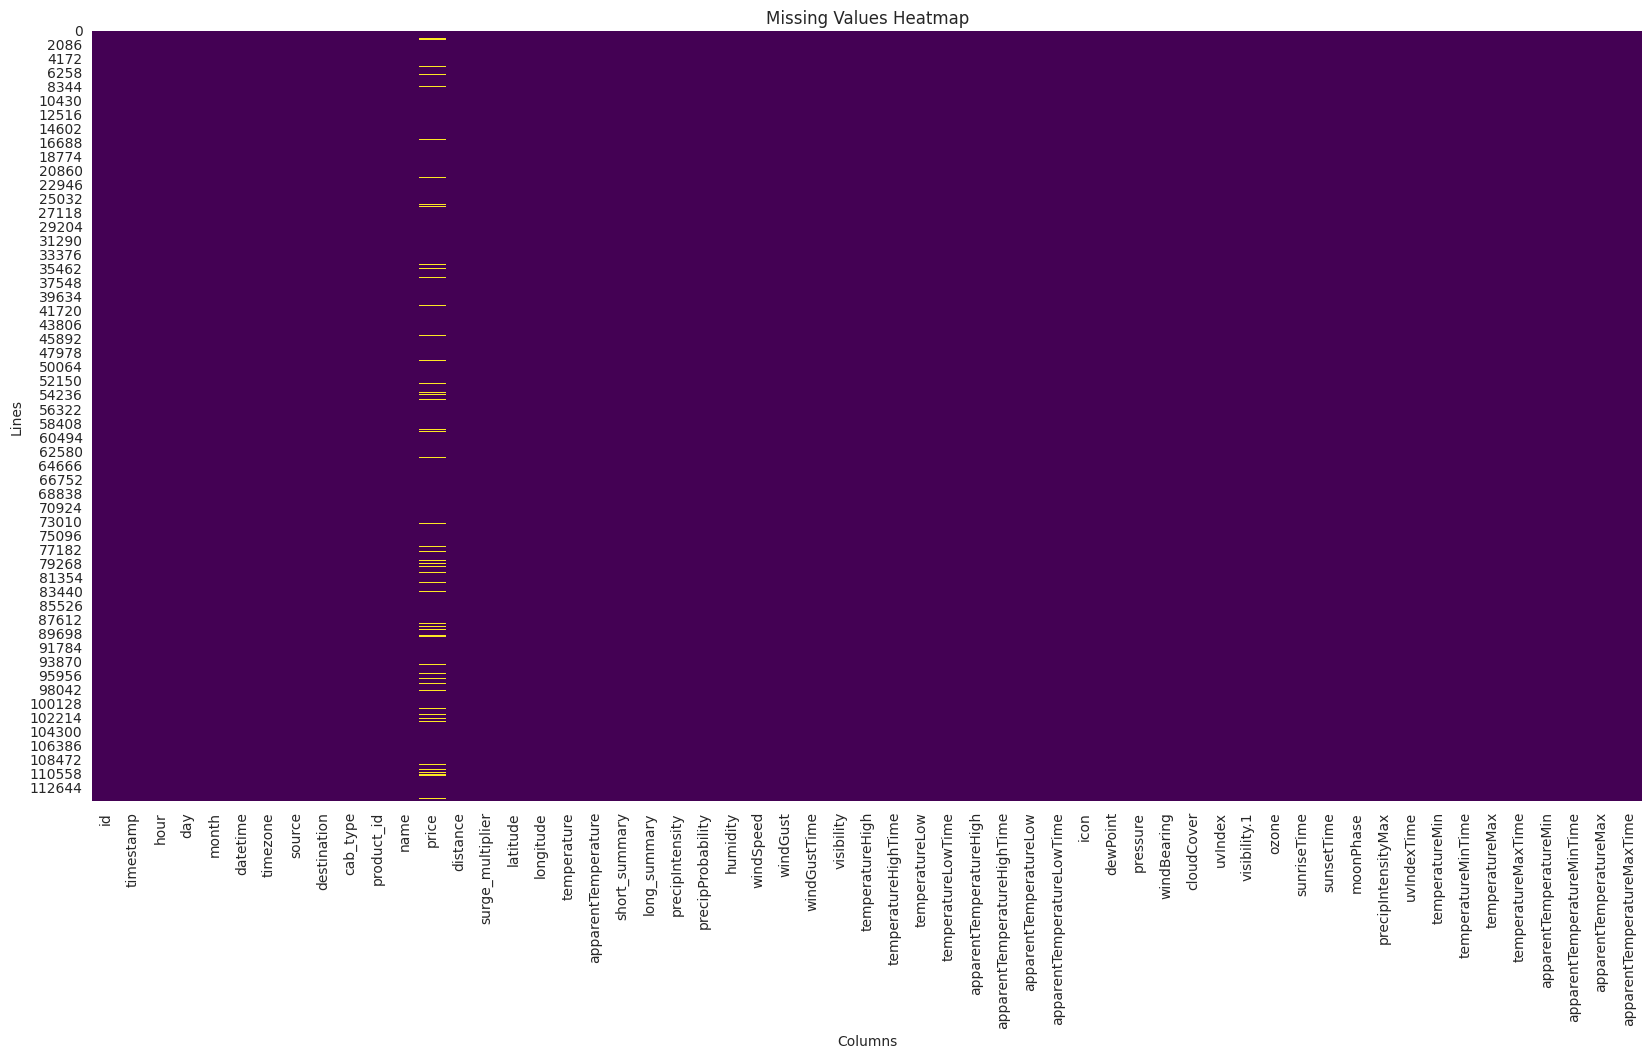

In [104]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values ​​Heatmap')
plt.xlabel('Columns')
plt.ylabel('Lines')
plt.show()

#### B. Bar chart of missing values

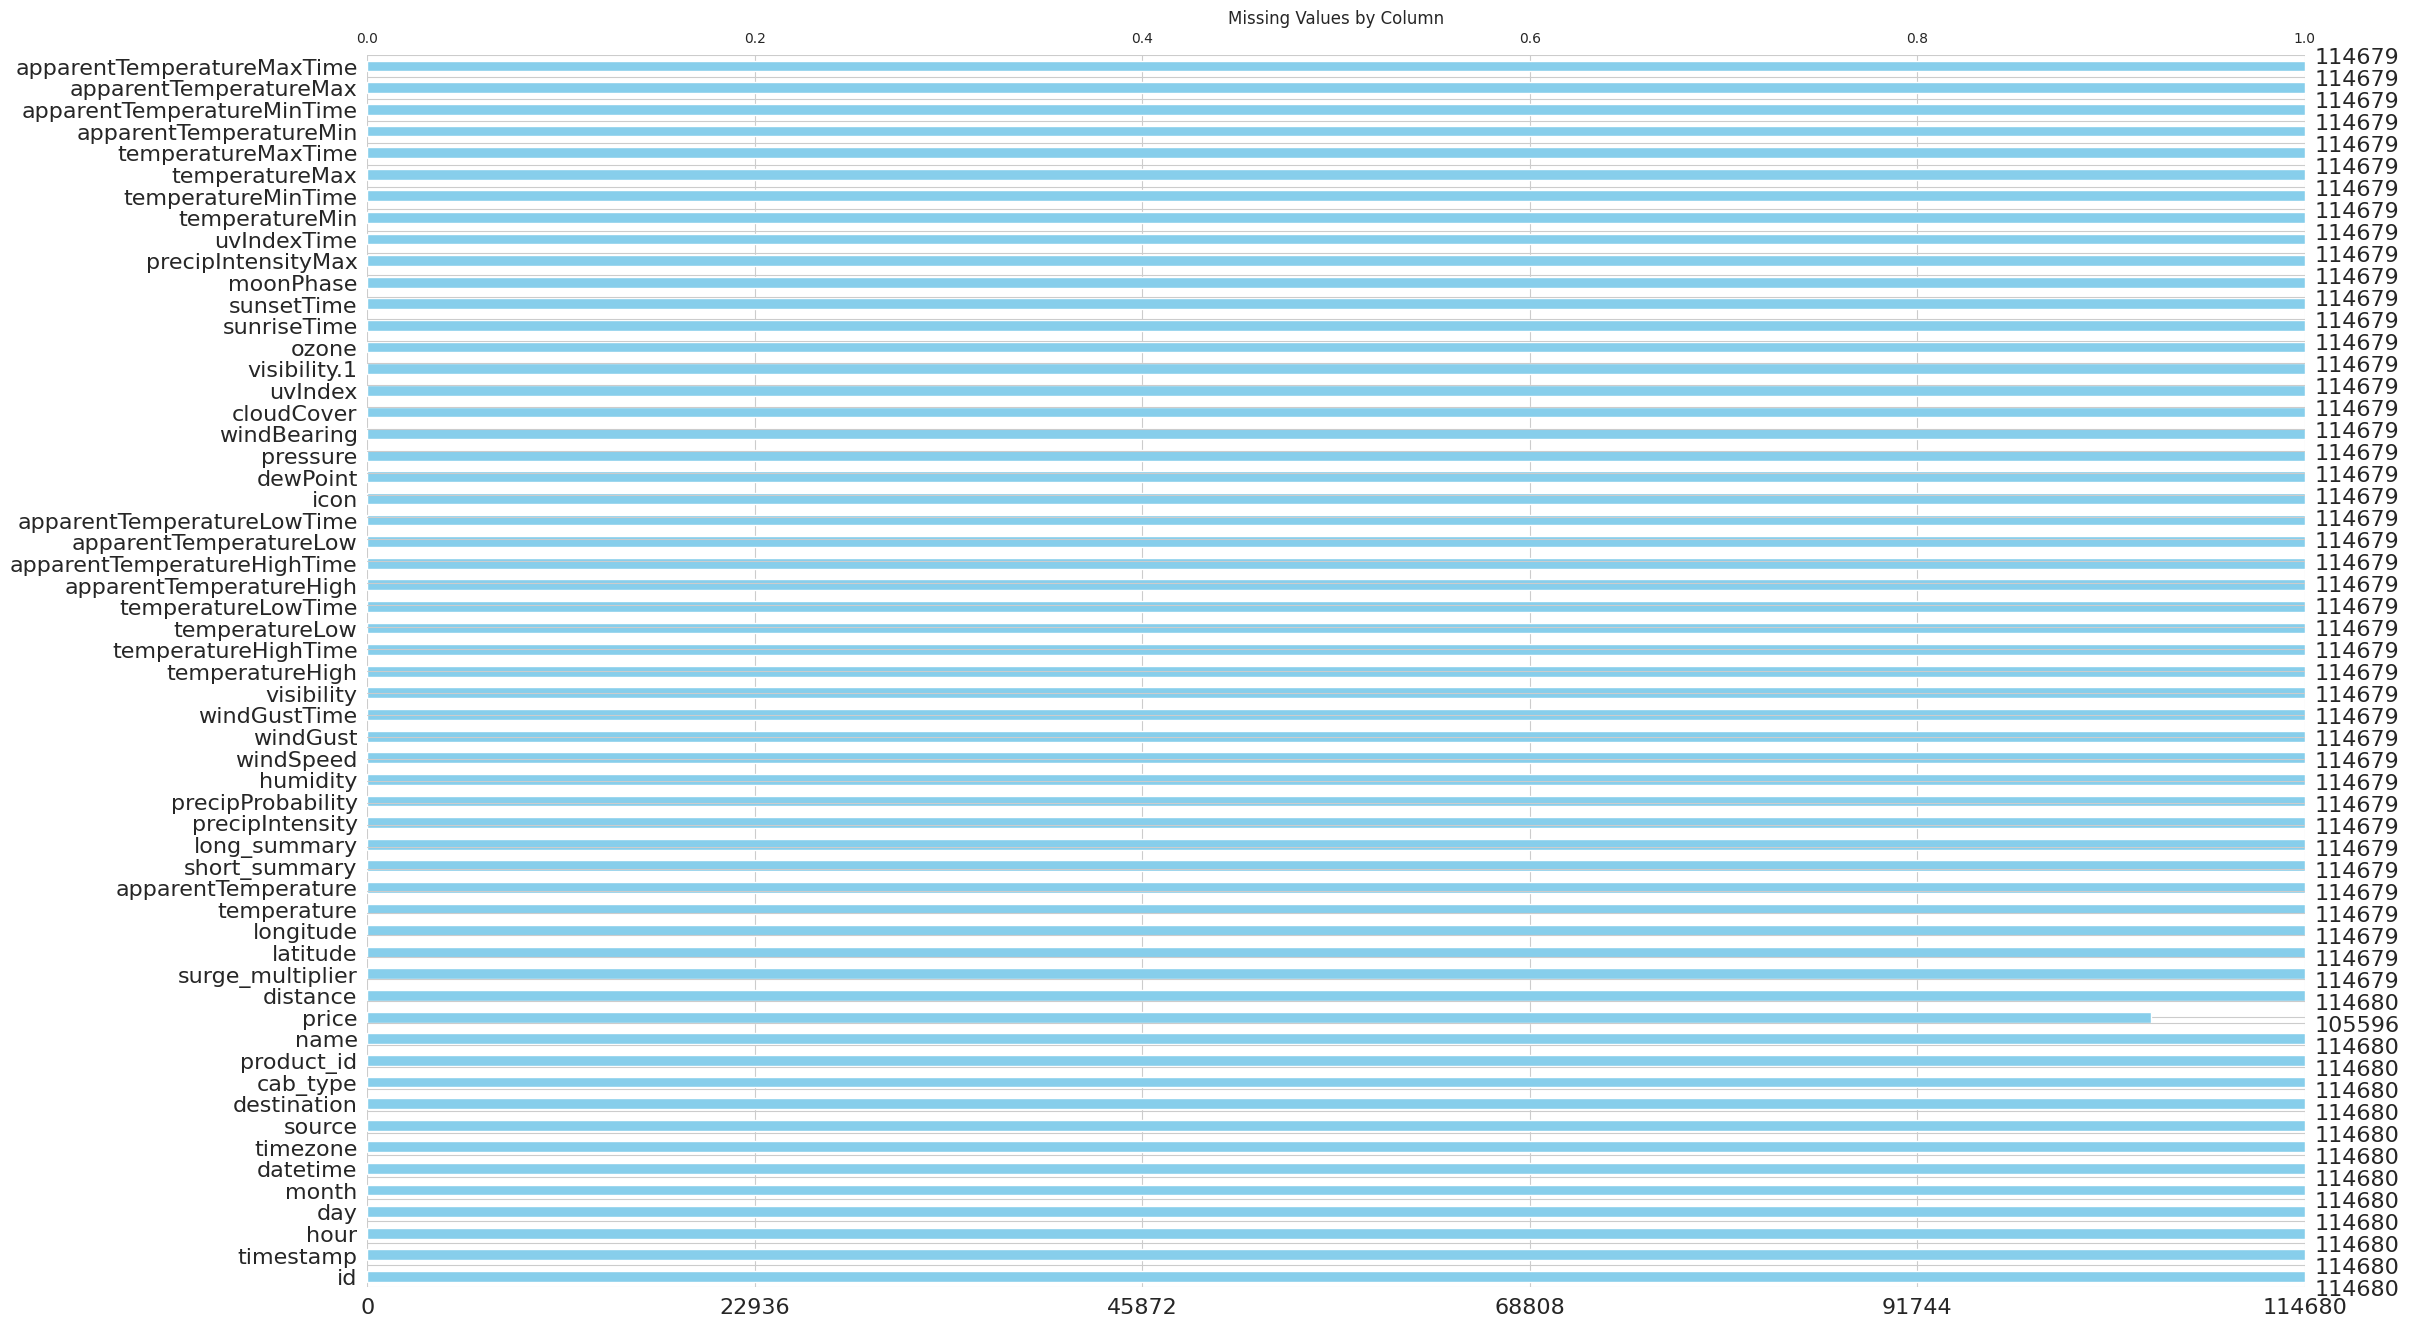

In [105]:
import missingno as msno

plt.figure(figsize=(20,6))
msno.bar(df, color='skyblue')
plt.title('Missing Values by Column')
plt.show()

#### C. Correlation graph between missing values

<Figure size 2000x1000 with 0 Axes>

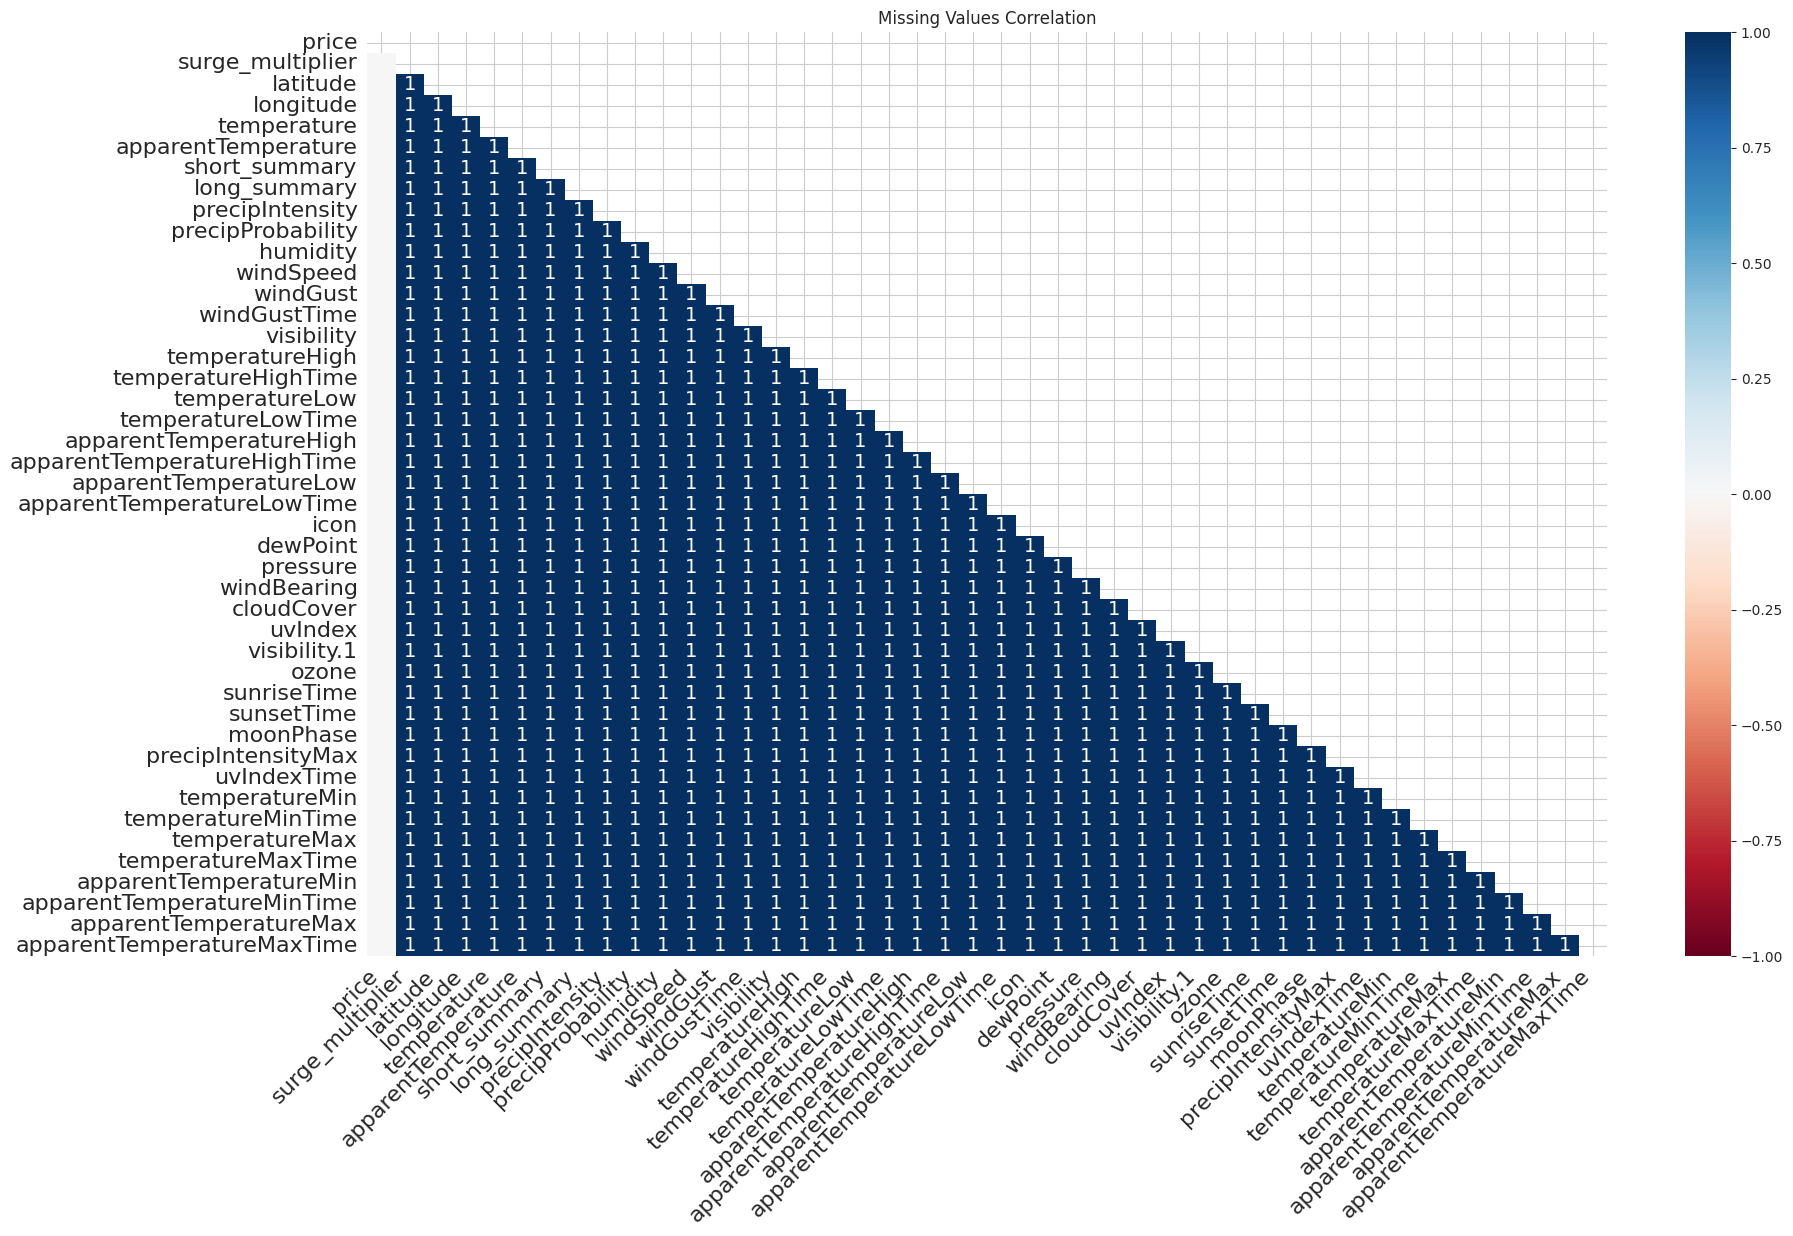

In [106]:
plt.figure(figsize=(20,10))
msno.heatmap(df)
plt.title('Missing Values ​​Correlation')
plt.show()

#### D. Histogram of 'price' column excluding NaNs

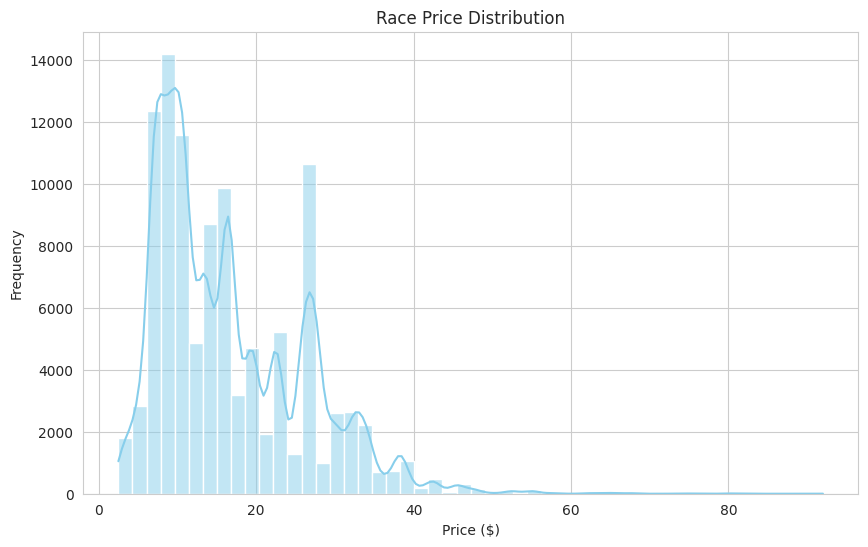

In [107]:
plt.figure(figsize=(10,6))
sns.histplot(df['price'].dropna(), bins=50, kde=True, color='skyblue')
plt.title('Race Price Distribution')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()

#### E. Boxplot to Identify Outliers

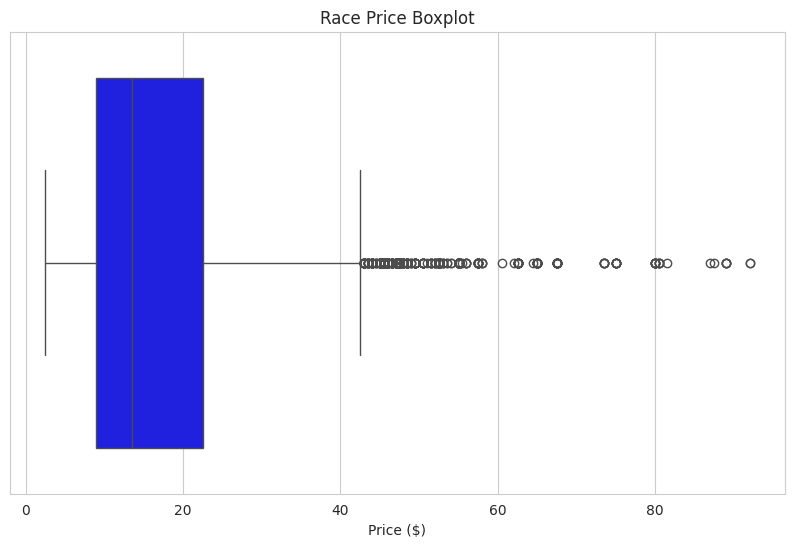

In [108]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['price'].dropna(), color='blue')
plt.title('Race Price Boxplot')
plt.xlabel('Price ($)')
plt.show()

#### F. Count of missing values of 'price' by 'cab_type'

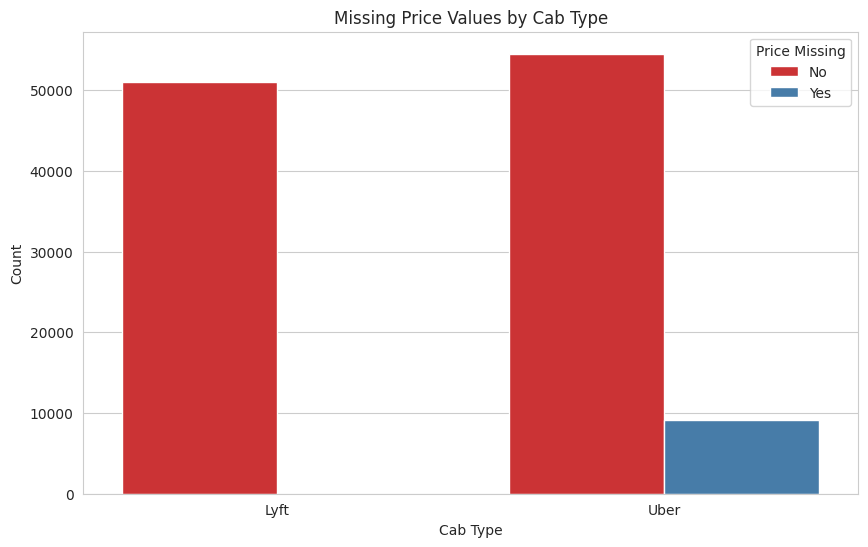

In [109]:
plt.figure(figsize=(10,6))
sns.countplot(x='cab_type', hue=df['price'].isnull(), data=df, palette='Set1')
plt.title('Missing Price Values ​​by Cab Type')
plt.xlabel('Cab Type')
plt.ylabel('Count')
plt.legend(title='Price Missing', labels=['No', 'Yes'])
plt.show()

#### G. Price vs Distance

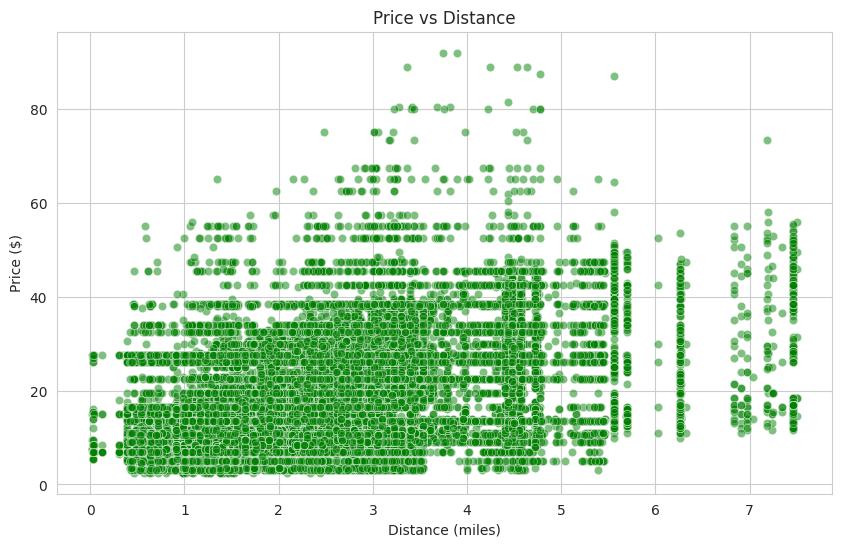

In [110]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='distance', y='price', data=df, alpha=0.5, color='green')
plt.title('Price vs Distance')
plt.xlabel('Distance (miles)')
plt.ylabel('Price ($)')
plt.show()

#### H. Price and Time of Day

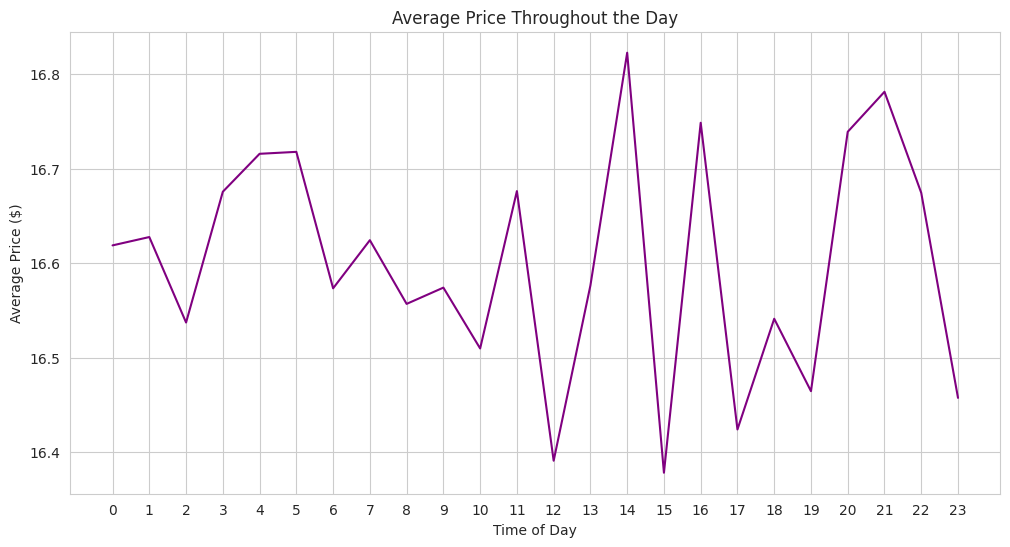

In [111]:
plt.figure(figsize=(12,6))
sns.lineplot(
    x='hour',
    y='price',
    data=df,
    errorbar=None,
    color='purple'
)
plt.title('Average Price Throughout the Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Price ($)')
plt.xticks(range(0,24))
plt.show()

#### I. Race Count by Cab Type

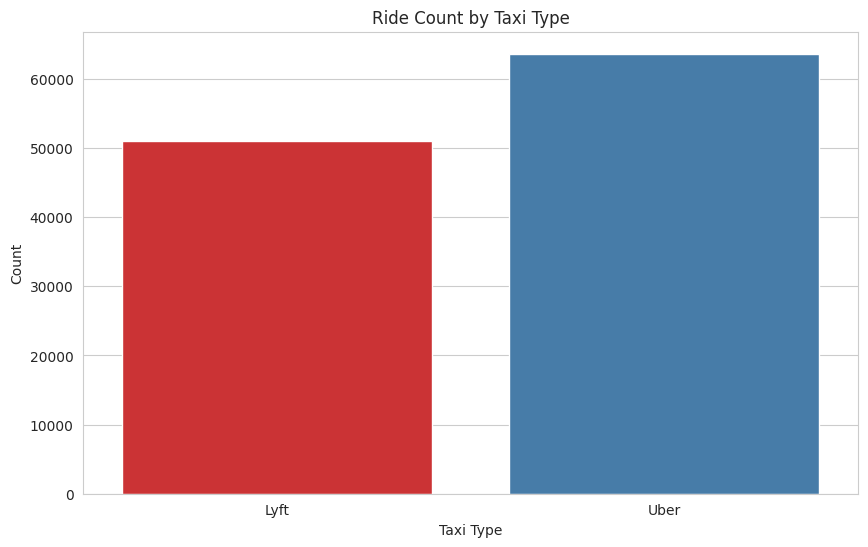

In [112]:
plt.figure(figsize=(10,6))
sns.countplot(
    x='cab_type',
    hue='cab_type',
    data=df,
    palette='Set1',
    dodge=False,
    legend=False
)
plt.title('Ride Count by Taxi Type')
plt.xlabel('Taxi Type')
plt.ylabel('Count')
plt.show()

#### J. Race Count by Origin

/tmp/ipykernel_1068/1014631275.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='source', data=df[df['source'].isin(top_sources)], palette='Set2')


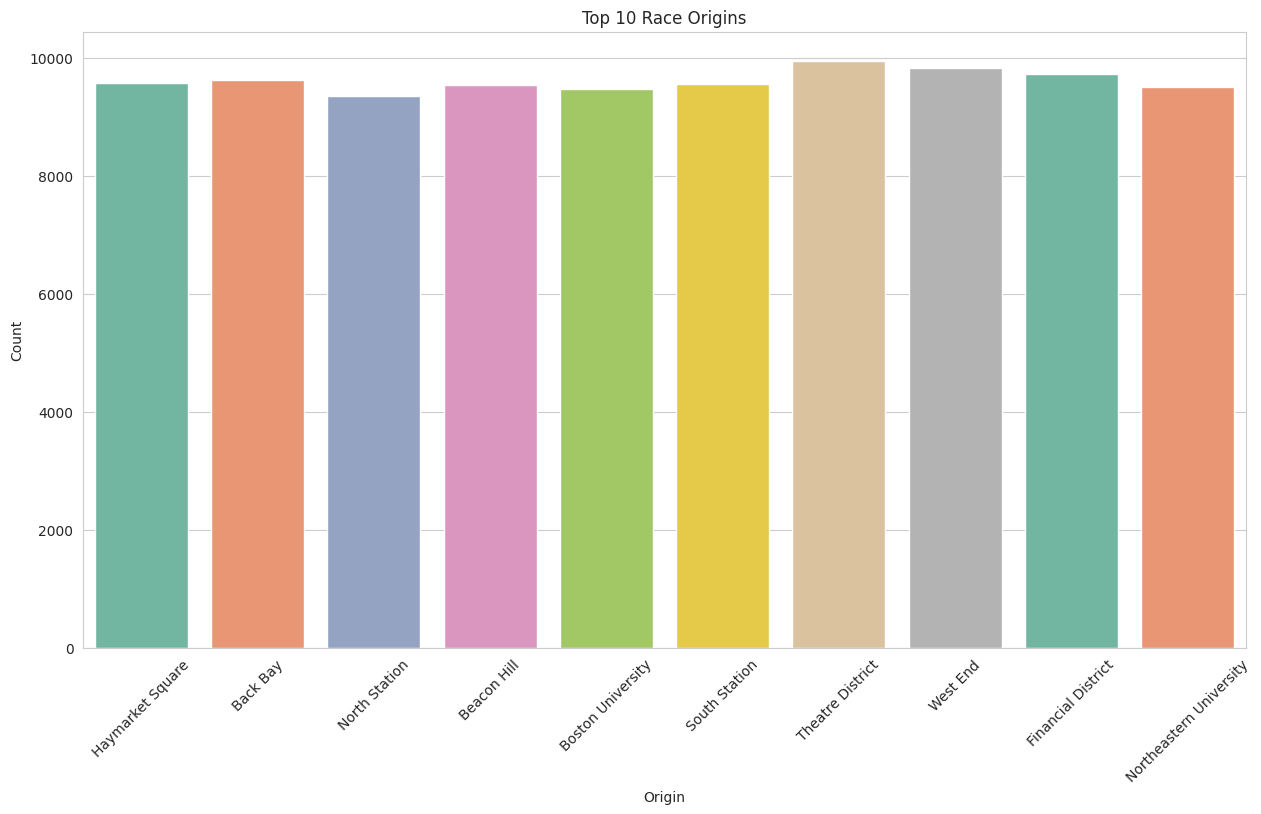

In [113]:
plt.figure(figsize=(15,8))
top_sources = df['source'].value_counts().nlargest(10).index
sns.countplot(x='source', data=df[df['source'].isin(top_sources)], palette='Set2')
plt.title('Top 10 Race Origins')
plt.xlabel('Origin')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### K. Geographic Map of the Races

In [114]:
import folium

sample_df = df.dropna(subset=['latitude', 'longitude']).sample(n=1000, random_state=42)

map_boston = folium.Map(location=[42.3601, -71.0589], zoom_start=12)

for _, row in sample_df.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=1,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(map_boston)

map_boston

#### L. Identifying Outliers with Boxplot

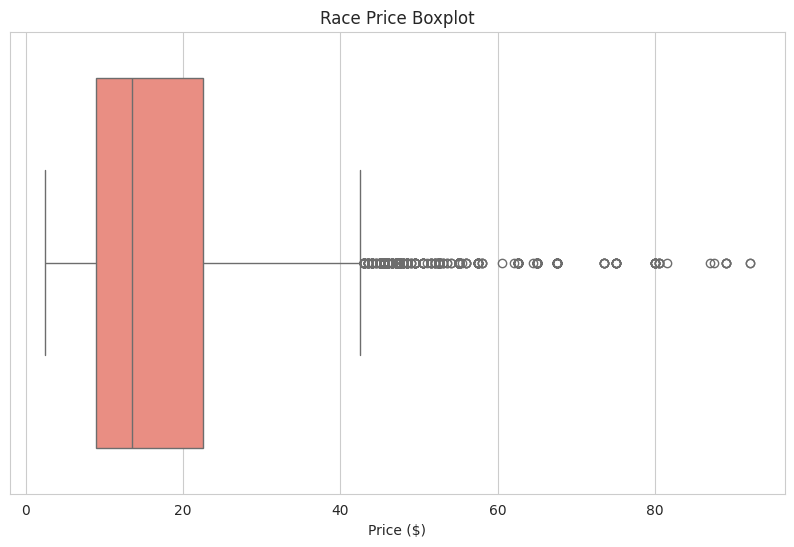

In [115]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['price'], color='salmon')
plt.title('Race Price Boxplot')
plt.xlabel('Price ($)')
plt.show()

#### M. Scatter Plot to Identify Outliers in Relation to Distance and Price

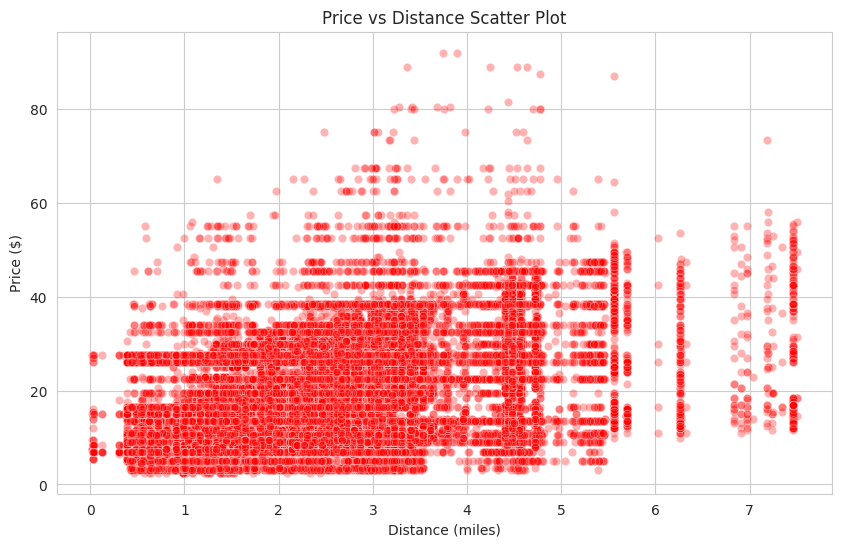

In [116]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='distance', y='price', data=df, alpha=0.3, color='red')
plt.title('Price vs Distance Scatter Plot')
plt.xlabel('Distance (miles)')
plt.ylabel('Price ($)')
plt.show()

### Removing unnecessary columns

In [117]:
drop_cols = ['timezone', 'product_id', 'short_summary', 'long_summary', 'windGustTime', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperatureMax', 'apparentTemperatureMaxTime']

df2 = df.drop(drop_cols, axis=1)
df2.columns = df2.columns.str.replace(' ', '_').str.lower()
df2 = df2.set_index('id')

### Data split

In [118]:
random_seed = 42

In [119]:
df_full_train, df_test = train_test_split(df2, test_size=0.2, random_state=random_seed)
len(df_full_train), len(df_test)

(91744, 22936)

In [120]:
df_full_train.sample(10)

,timestamp,hour,day,month,datetime,source,destination,cab_type,name,price,...,latitude,longitude,temperature,apparenttemperature,precipintensity,precipprobability,humidity,windspeed,windgust,visibility
id,,,,,,,,,,,,,,,,,,,,,
ce9b56c6-df16-4cf8-aae5-e30b22af649d,1.545037e+09,9,17,12,2018-12-17 09:00:04,North End,Theatre District,Uber,UberXL,13.5,...,42.3644,-71.0661,35.84,29.23,0.0092,0.74,0.94,8.52,10.39,3.606
f06678a0-5c3a-4c44-9e5c-f8bca1d797e4,1.543809e+09,3,3,12,2018-12-03 03:58:01,Northeastern University,North Station,Lyft,Shared,3.5,...,42.2148,-71.0330,48.12,48.12,0.0020,0.10,0.95,2.56,2.56,4.730
9b666c66-5bee-4903-82e4-d003fab96d4c,1.545034e+09,8,17,12,2018-12-17 08:05:11,Boston University,West End,Lyft,Lux,19.5,...,42.2148,-71.0330,37.83,30.56,0.0216,1.00,0.91,10.88,10.88,3.139
f482dd7f-1e7b-422d-9098-3492d7ef643e,1.544782e+09,10,14,12,2018-12-14 10:10:03,Theatre District,North End,Uber,UberXL,14.0,...,42.3519,-71.0643,27.71,27.71,0.0000,0.00,0.79,2.96,4.75,9.641
5df17d9c-fff1-4e77-a010-da90156814b6,1.543414e+09,14,28,11,2018-11-28 14:14:08,Fenway,Back Bay,Uber,Black SUV,26.5,...,42.3661,-71.0631,39.02,34.01,0.0000,0.00,0.65,6.91,9.33,9.908
b6f1ac5b-1c84-45df-9411-a667742b5180,1.543415e+09,14,28,11,2018-11-28 14:17:07,Northeastern University,North Station,Uber,UberX,13.0,...,42.3661,-71.0631,39.02,34.01,0.0000,0.00,0.65,6.91,9.33,9.908
5a0829e9-0134-4288-8921-09867469bfd1,1.544817e+09,19,14,12,2018-12-14 19:45:03,South Station,North Station,Uber,UberPool,7.5,...,42.3661,-71.0631,45.82,43.92,0.0000,0.00,0.53,4.16,4.16,9.874
860c7775-5cac-49e5-ab44-54f496fb3f34,1.545077e+09,19,17,12,2018-12-17 19:55:11,Back Bay,North End,Uber,Taxi,NaN,...,42.3398,-71.0892,40.78,36.05,0.0000,0.00,0.69,7.06,9.44,9.973
411d59a4-107f-4229-8dd4-35f135f20cf7,1.544714e+09,15,13,12,2018-12-13 15:10:17,Theatre District,Northeastern University,Lyft,Shared,7.0,...,42.3519,-71.0643,28.42,28.42,0.0000,0.00,0.57,2.81,4.06,9.725


In [121]:
df_full_train.shape

(91744, 22)

### Missing values

In [122]:
df_full_train.isnull().sum()

timestamp                 0
hour                      0
day                       0
month                     0
datetime                  0
source                    0
destination               0
cab_type                  0
name                      0
price                  7213
distance                  0
surge_multiplier          1
latitude                  1
longitude                 1
temperature               1
apparenttemperature       1
precipintensity           1
precipprobability         1
humidity                  1
windspeed                 1
windgust                  1
visibility                1
dtype: int64

In [123]:
print(f'Percentage of missing values in price column {round(df_full_train.isnull().sum().sum()*100/df_full_train.shape[0],2)}%')

Percentage of missing values in price column 7.87%


In [124]:
df_full_train = df_full_train.dropna()

In [125]:
df_full_train.columns

Index(['timestamp', 'hour', 'day', 'month', 'datetime', 'source',
       'destination', 'cab_type', 'name', 'price', 'distance',
       'surge_multiplier', 'latitude', 'longitude', 'temperature',
       'apparenttemperature', 'precipintensity', 'precipprobability',
       'humidity', 'windspeed', 'windgust', 'visibility'],
      dtype='object')

In [126]:
df_full_train['timestamp'] = pd.to_datetime(df_full_train['timestamp'], unit='s')
df_full_train['datetime'] = pd.to_datetime(df_full_train['datetime'])

In [127]:
numerical_cols = ['price', 'distance', 'temperature', 'humidity', 'precipintensity', 'visibility']
cat_cols = ['source', 'destination', 'cab_type', 'name']
time_cols = ['hour', 'day']

In [128]:
def plot_univariate(df, list_vars):

    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 10))
    for v in range(len(list_vars)):
        plt.subplot(3, 2, v+1)
        sns.histplot(df[list_vars[v]], bins=50, kde=False)
        plt.title(f'Distribution of {list_vars[v]}')
        plt.xlabel(f'{list_vars[v]}')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

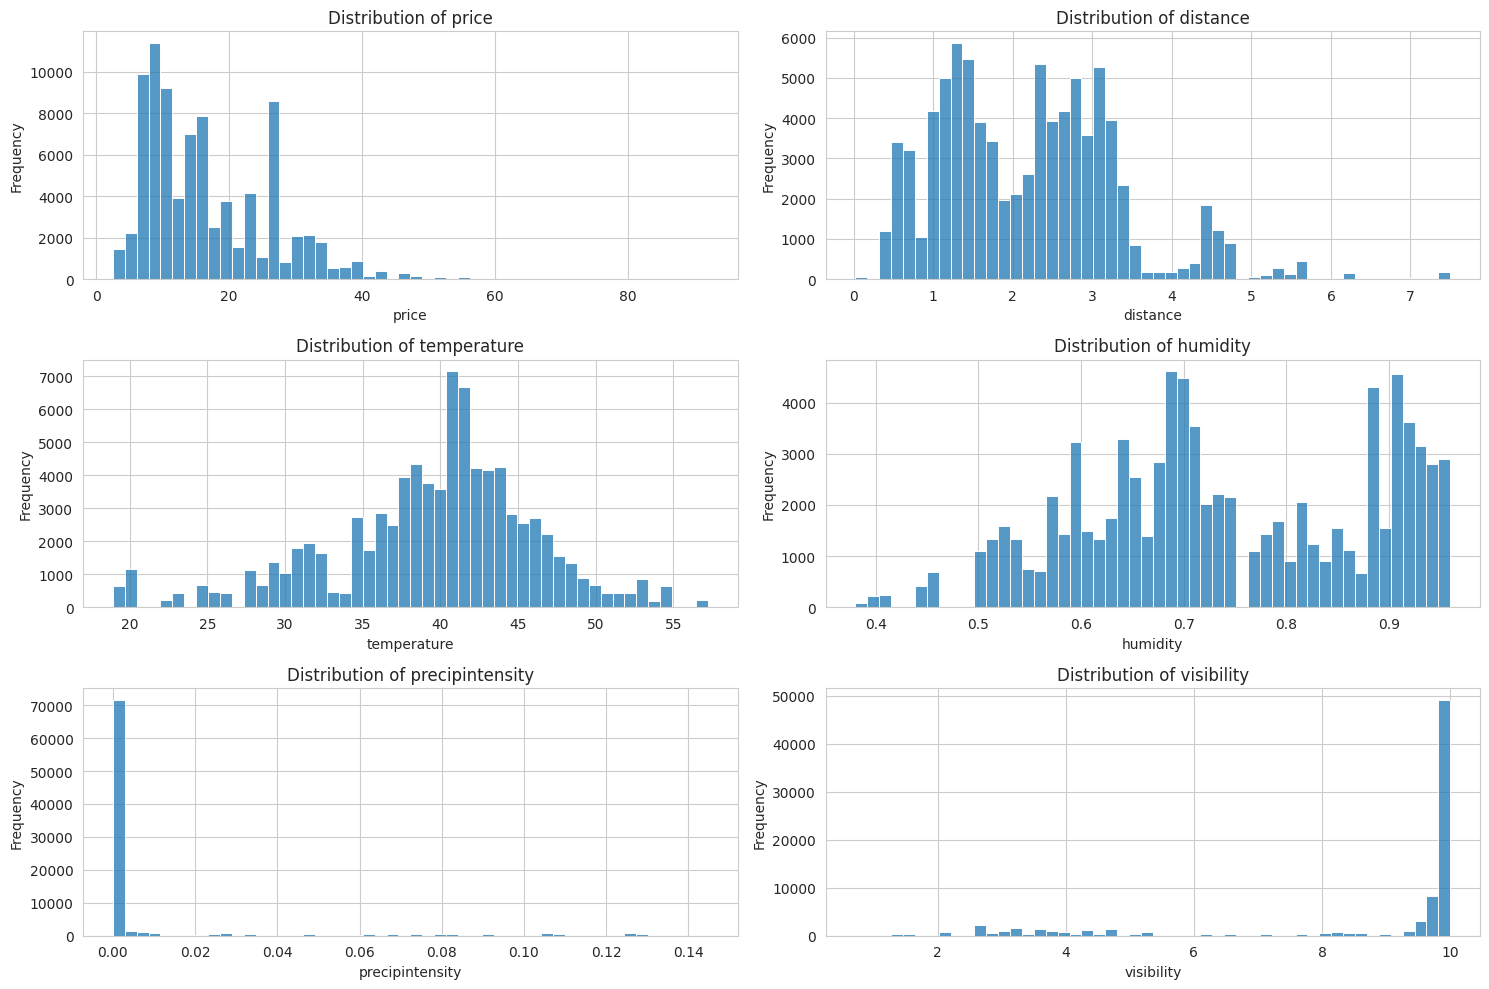

In [129]:
plot_univariate(df_full_train, numerical_cols)

In [130]:
def plot_categorical(df, list_vars, limit_cols=10):

    sns.set_style("whitegrid")
    plt.figure(figsize=(20, 15))
    for v in range(len(list_vars)):
        plt.subplot(2, 2, v+1)
        sns.countplot(data=df, y=list_vars[v], hue=list_vars[v],
                      order=df[list_vars[v]].value_counts().iloc[:limit_cols].index, palette='Spectral')
        plt.title(f'Count Distribution of {list_vars[v]}')
        plt.xlabel(f'{list_vars[v]}')
        plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

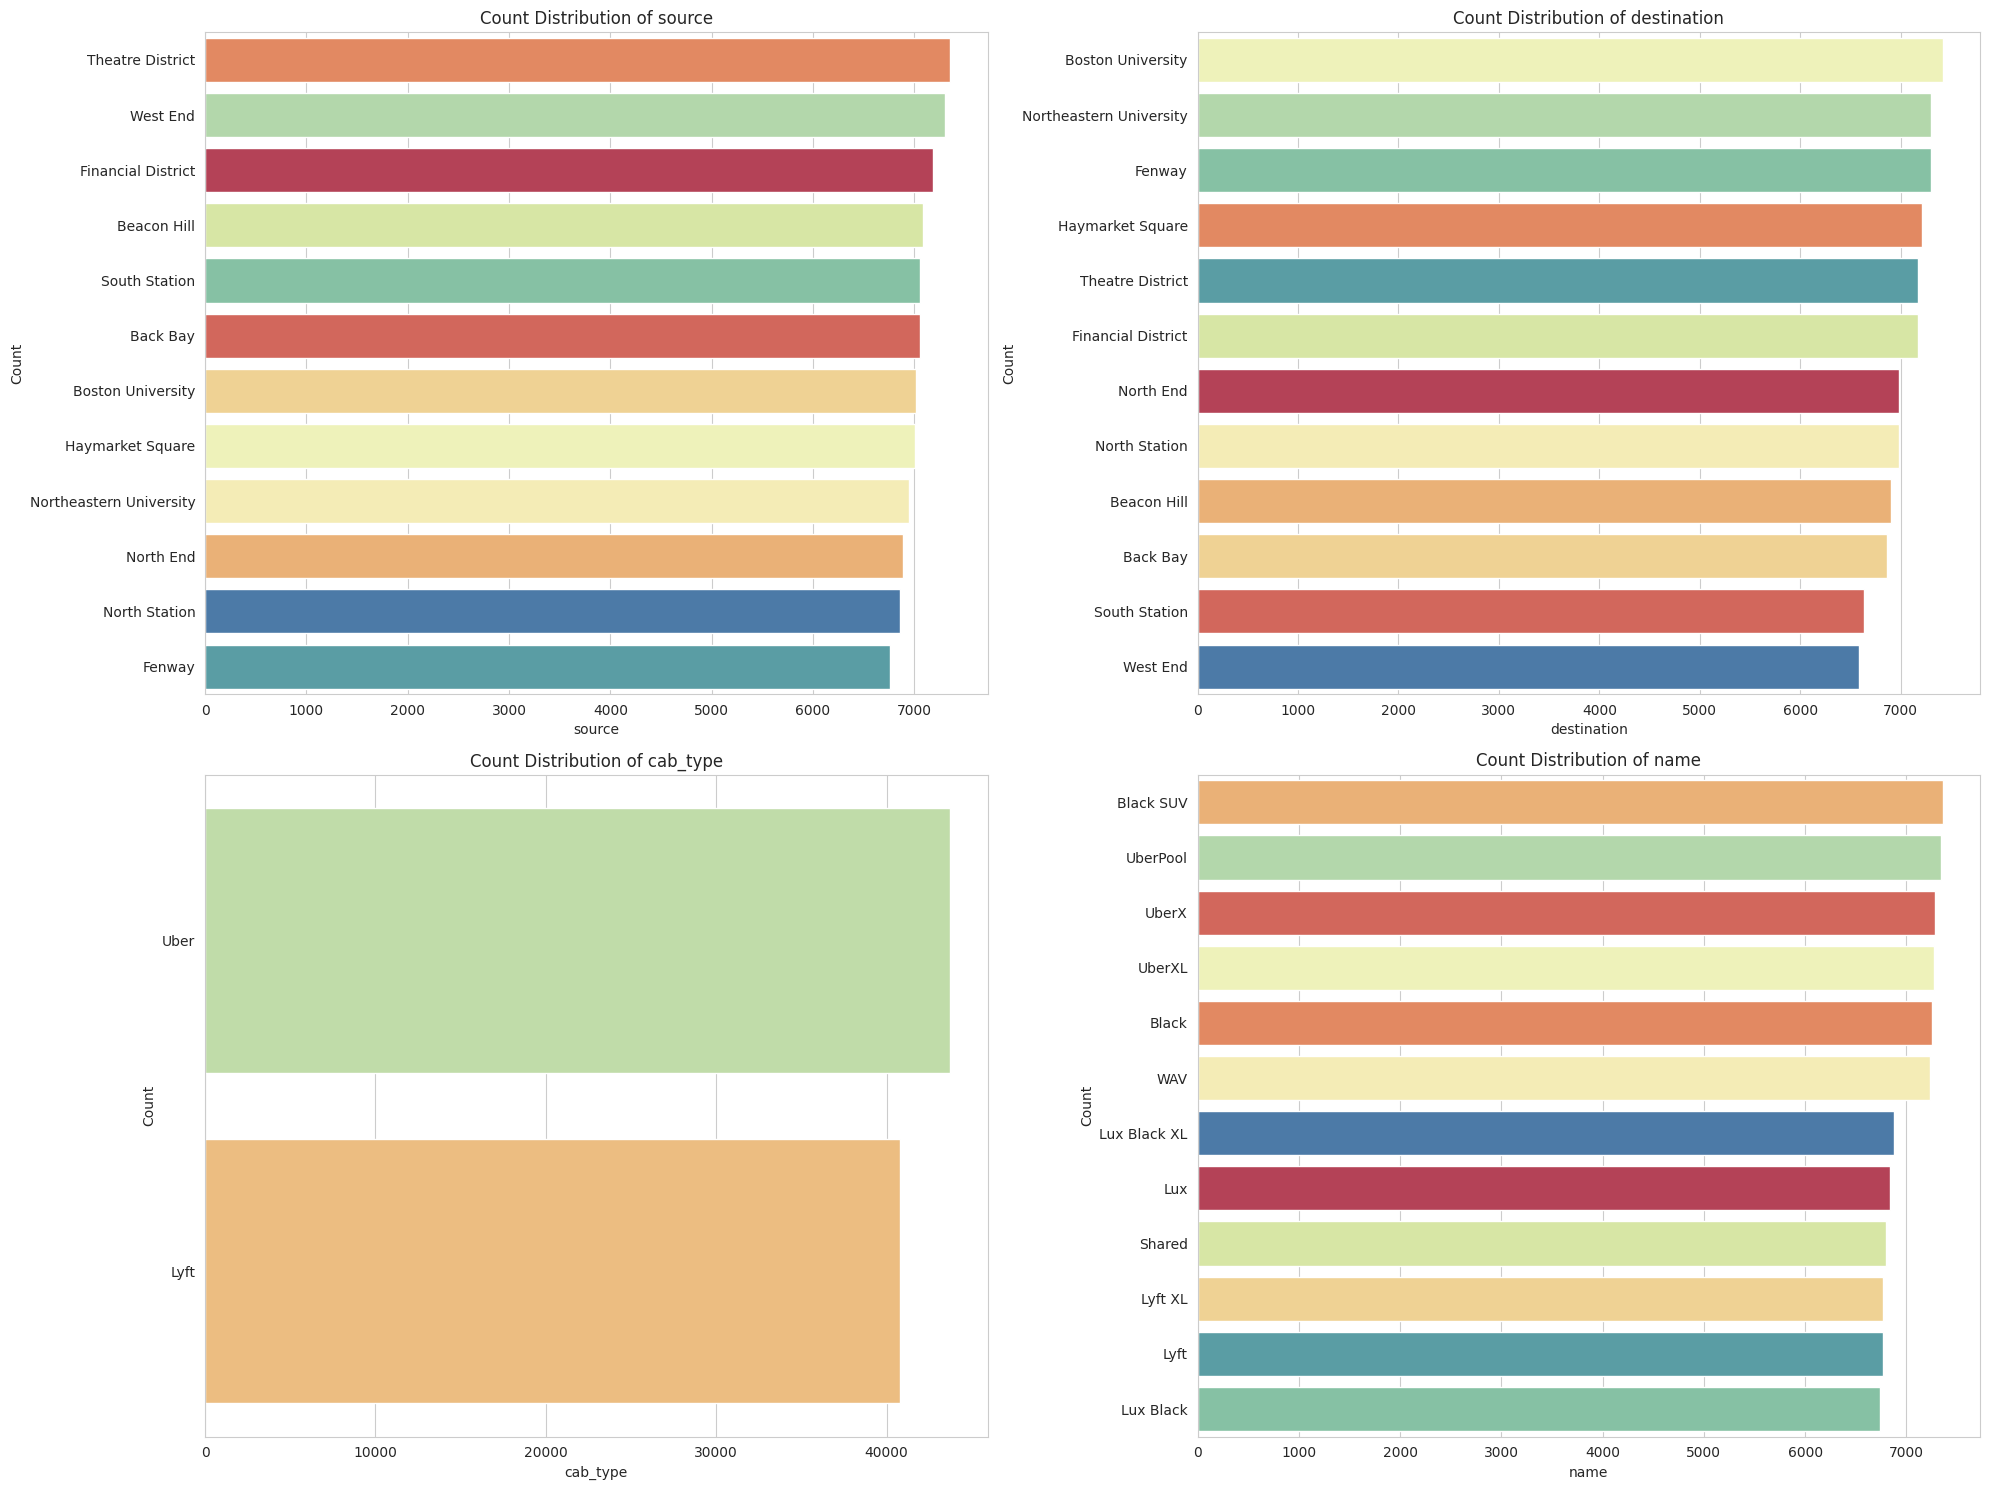

In [131]:
plot_categorical(df_full_train, cat_cols, 15)

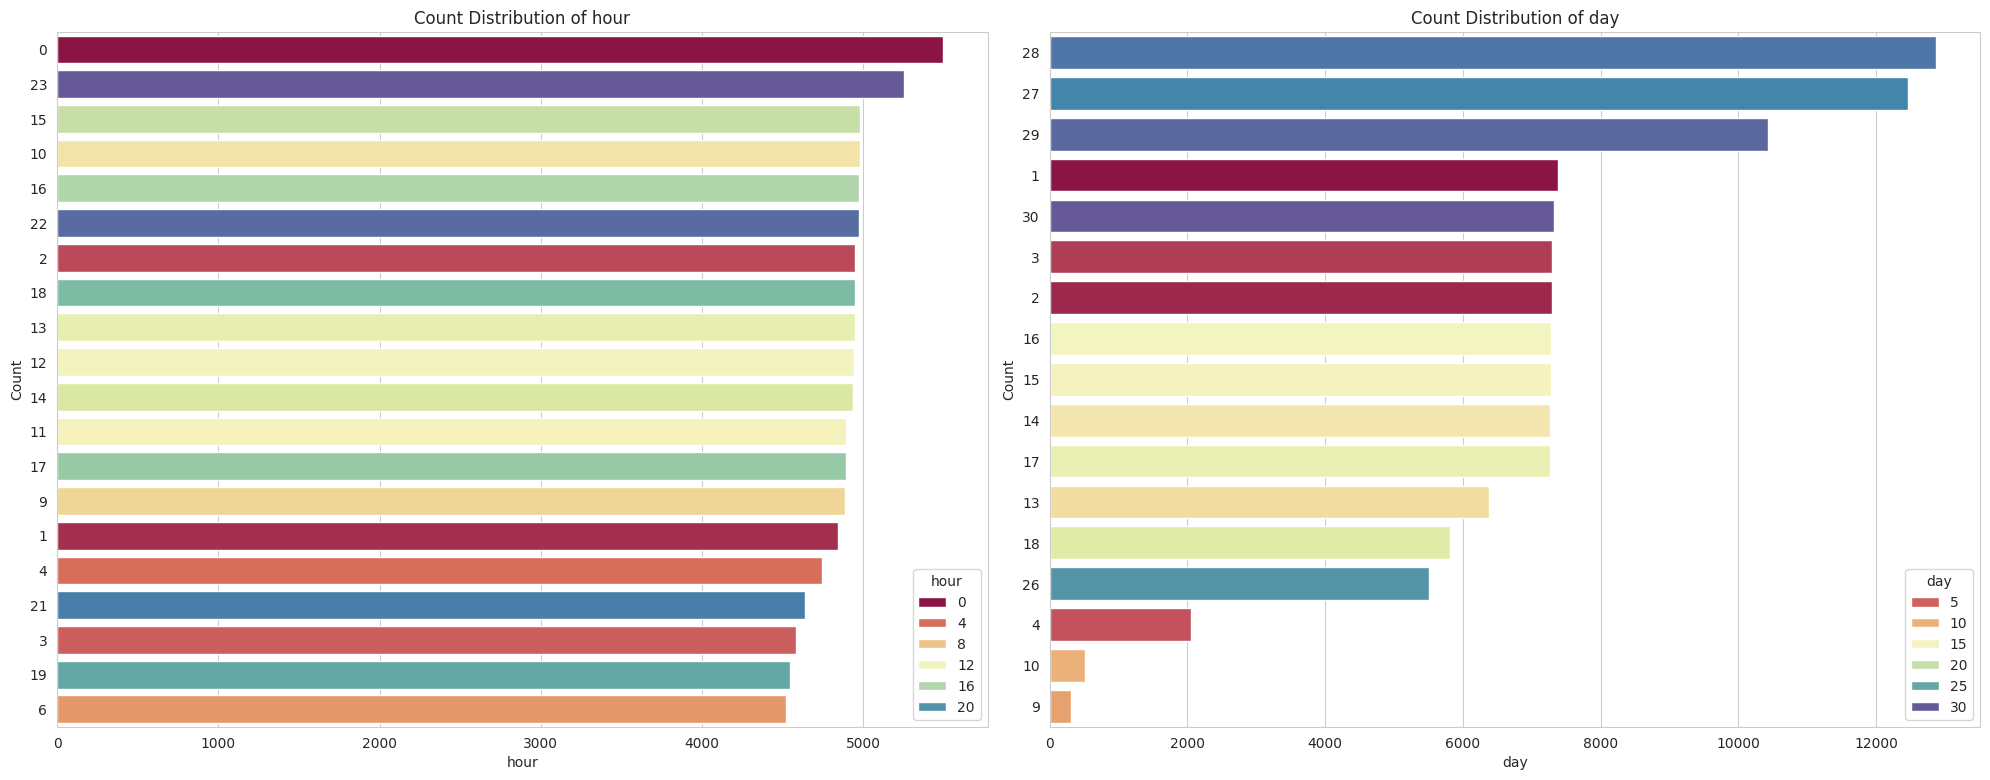

In [132]:
plot_categorical(df2, time_cols, 20)

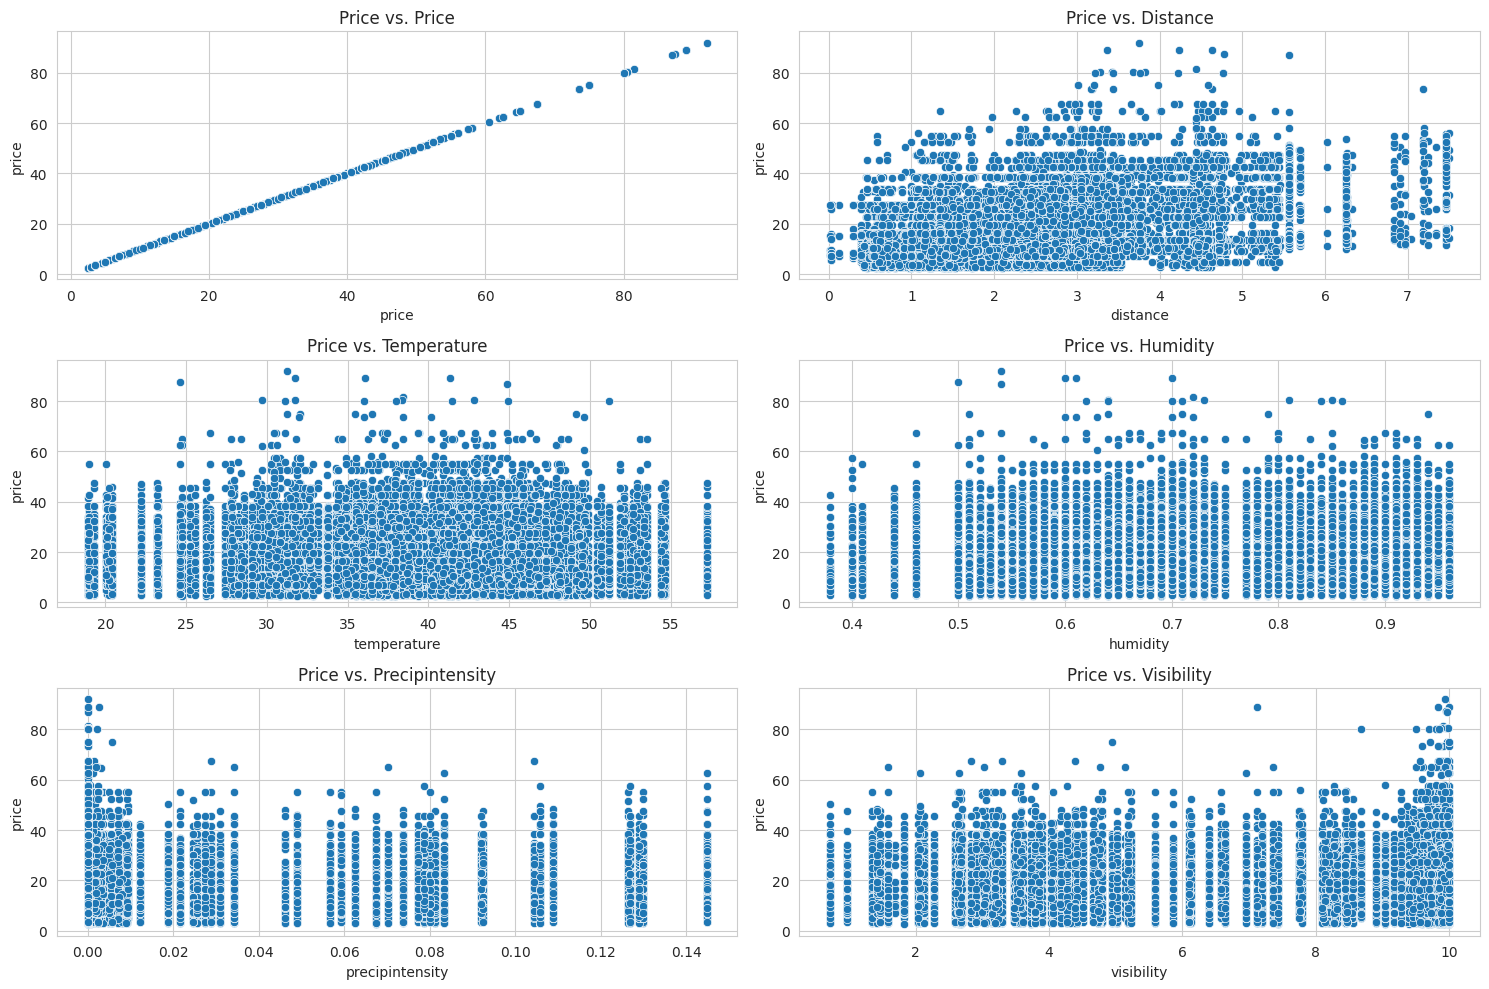

In [133]:
plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=df_full_train[feature], y=df_full_train['price'])
    plt.title(f'Price vs. {feature.capitalize()}')

plt.tight_layout()
plt.show()

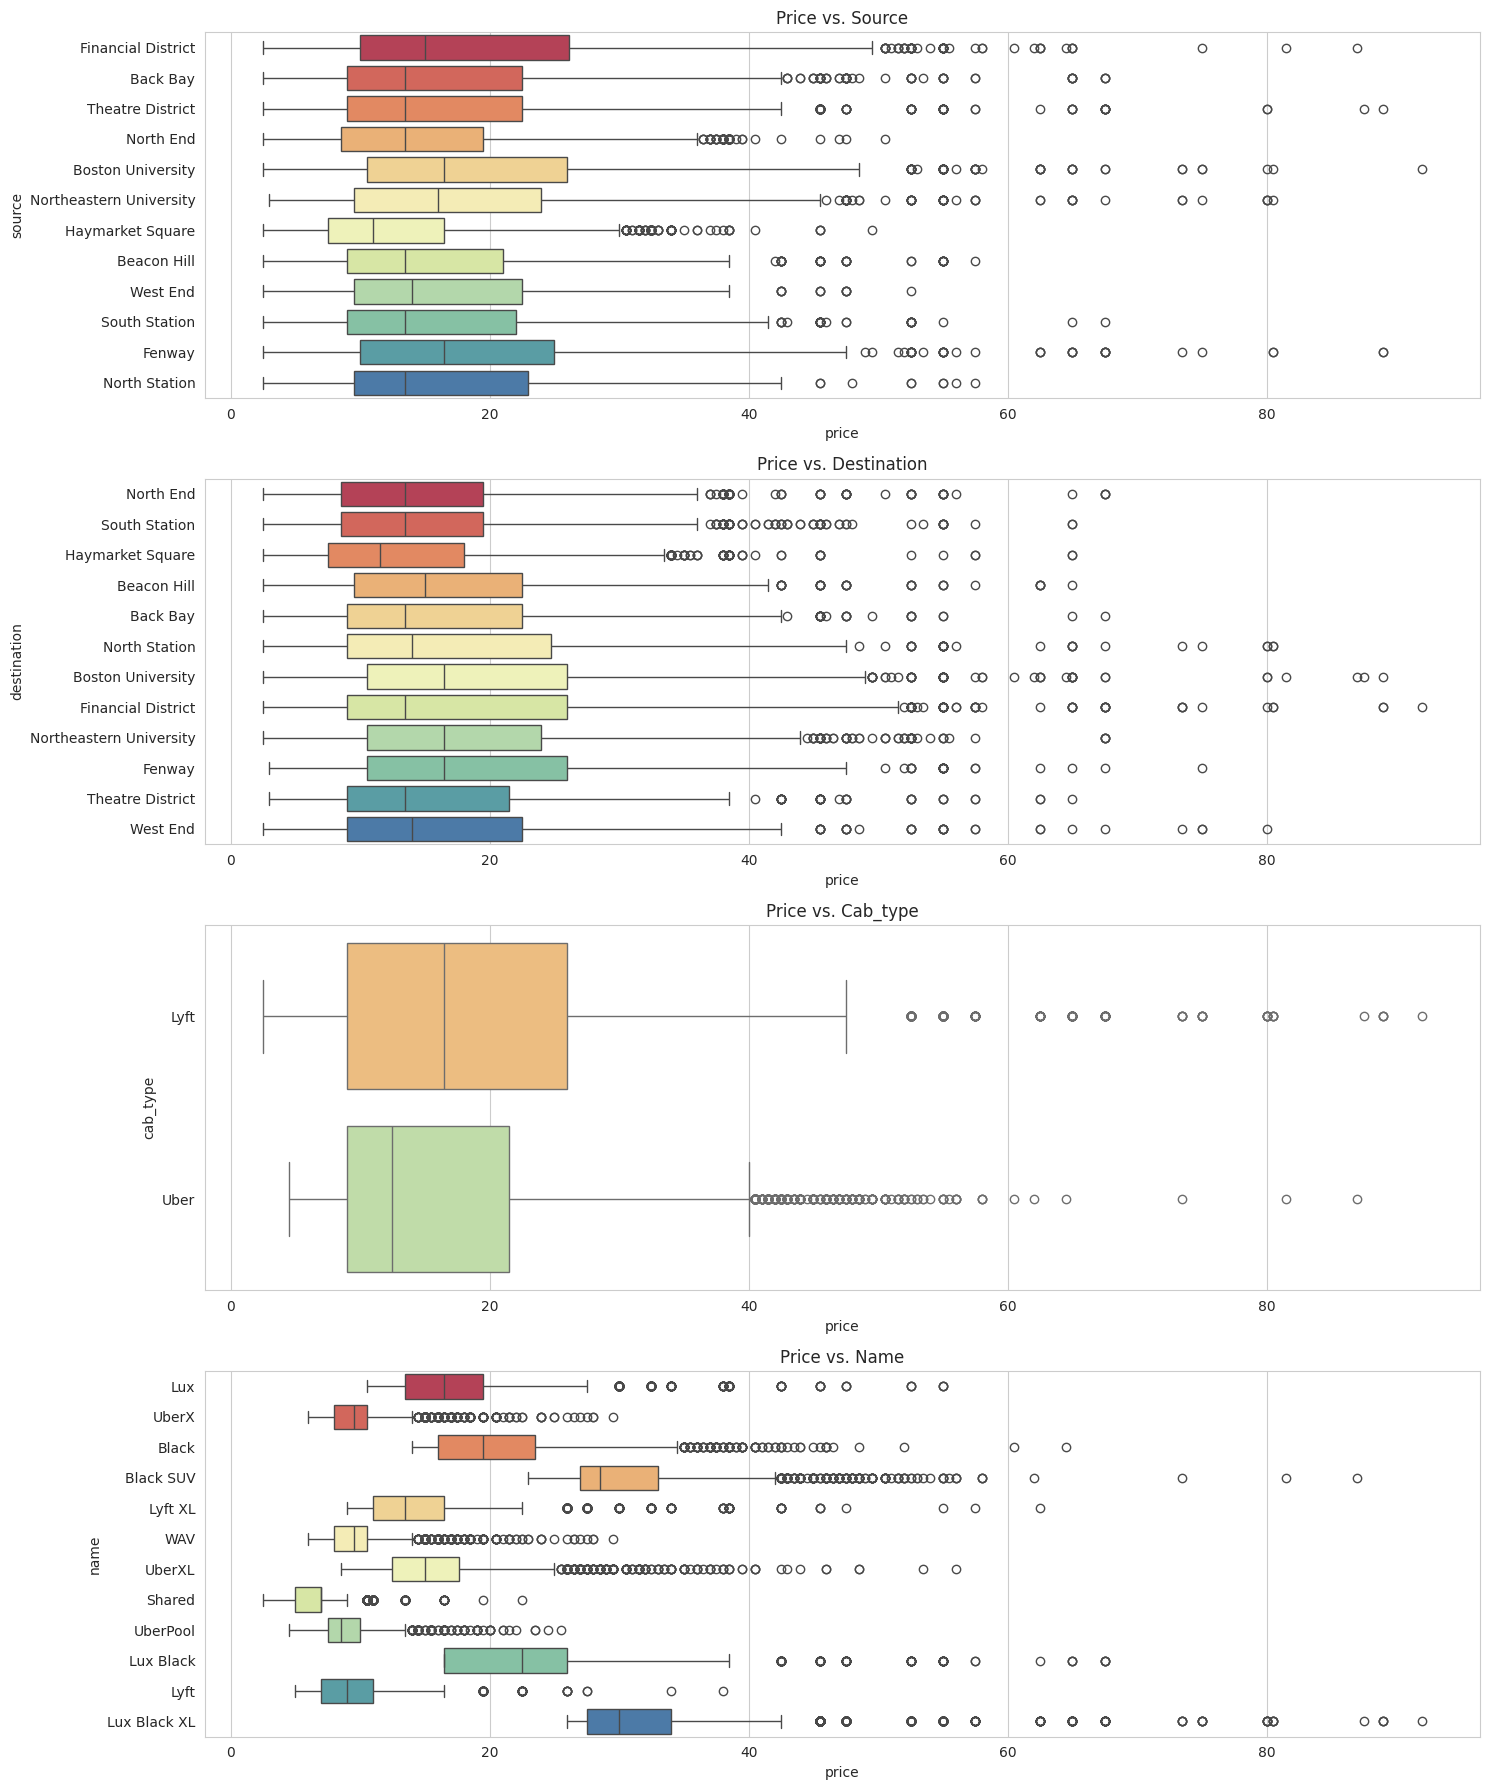

In [134]:
plt.figure(figsize=(15, 18))

for i, feature in enumerate(cat_cols, 1):
    plt.subplot(4, 1, i)
    sns.boxplot(x='price', y=feature, data=df_full_train, hue=feature, palette='Spectral')
    plt.title(f'Price vs. {feature.capitalize()}')

plt.tight_layout()
plt.show()

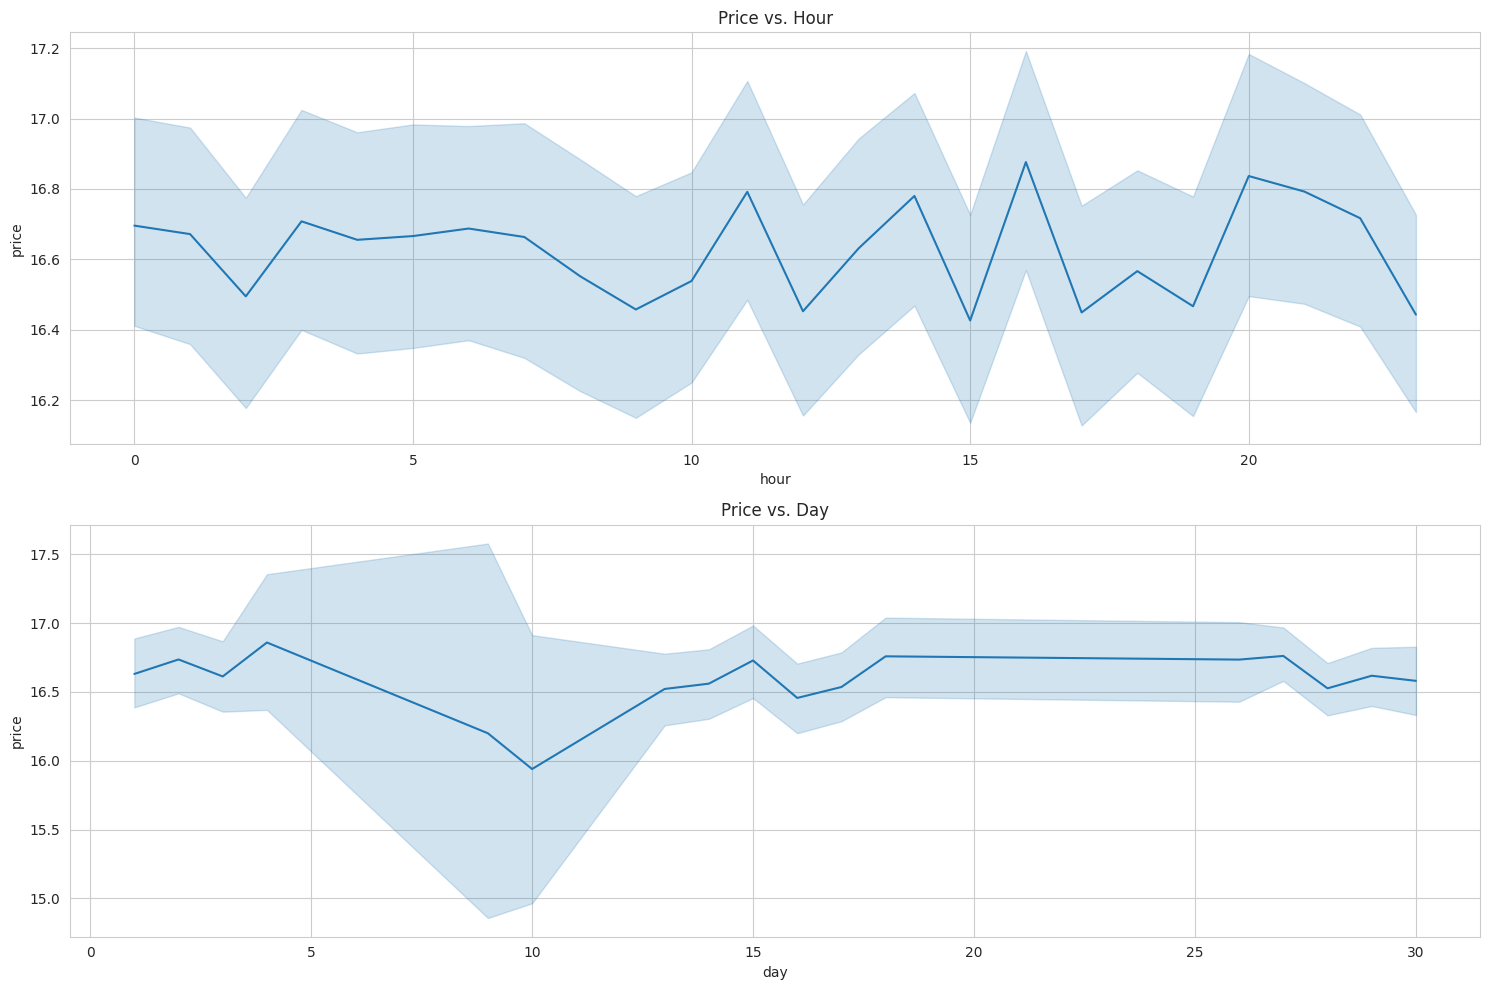

In [135]:
plt.figure(figsize=(15, 10))

for i, feature in enumerate(time_cols, 1):
    plt.subplot(2, 1, i)
    sns.lineplot(x=feature, y='price', data=df_full_train)
    plt.title(f'Price vs. {feature.capitalize()}')

plt.tight_layout()
plt.show()

In [136]:
m = folium.Map(location=[df_full_train['latitude'].mean(), df_full_train['longitude'].mean()], zoom_start=12)

heat_data = [[row['latitude'], row['longitude'], row['price']] for index, row in df_full_train.iterrows()]

HeatMap(heat_data, radius=15).add_to(m)

### Imputation of Missing Values

In [137]:
df_full_train['surge_multiplier'] = df_full_train['surge_multiplier'].fillna(df_full_train['surge_multiplier'].mean())
df_full_train['latitude'] = df_full_train['latitude'].fillna(df_full_train['latitude'].mean())
df_full_train['longitude'] = df_full_train['longitude'].fillna(df_full_train['longitude'].mean())

numerical_impute_cols = [
    'temperature', 'precipintensity', 
    'precipprobability', 'humidity', 'windspeed', 'windgust', 'visibility'
]

for col in numerical_impute_cols:
    df_full_train[col] = df_full_train[col].fillna(df_full_train[col].mean())

print("Missing values ​​after imputation:")
print(df_full_train.isnull().sum())

Missing values ​​after imputation:
timestamp              0
hour                   0
day                    0
month                  0
datetime               0
source                 0
destination            0
cab_type               0
name                   0
price                  0
distance               0
surge_multiplier       0
latitude               0
longitude              0
temperature            0
apparenttemperature    0
precipintensity        0
precipprobability      0
humidity               0
windspeed              0
windgust               0
visibility             0
dtype: int64
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.1s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   

### Feature Engineering

#### Temporal Feature Extraction

In [138]:
df_full_train['day_of_week'] = df_full_train['timestamp'].dt.dayofweek
df_full_train['is_weekend'] = df_full_train['day_of_week'].apply(lambda x: 1 if x >=5 else 0)

#### Creating Interaction Features

In [139]:
df_full_train['distance_surge'] = df_full_train['distance'] * df_full_train['surge_multiplier']

#### Feature Selection

#### Collinearity Removal

In [140]:
numerical_cols = df_full_train.select_dtypes(include=[np.number])

corr_matrix = numerical_cols.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

print(f"Features to be removed due to high correlation: {to_drop}")

df_full_train.drop(columns=to_drop, inplace=True)

Features to be removed due to high correlation: ['month', 'apparenttemperature', 'precipprobability', 'windgust', 'distance_surge']


In [141]:
print(df_full_train.shape)
print(df_full_train.head())

(84530, 20)
                                               timestamp  hour  day  \
id                                                                    
64a6e4b8-7d4a-43bd-98d9-698d4f2970d4 2018-12-13 13:50:11    13   13   
941522df-1fa4-421b-bede-07c6bfd102d0 2018-11-29 06:53:01     6   29   
4cd1e6d4-34f0-4a90-984c-152d2a99c618 2018-12-04 00:23:03     0    4   
39e82b47-e966-4924-8033-f9667820cdf6 2018-12-18 11:40:11    11   18   
ea721e3e-28fb-4e8d-b7c9-90e7b85fd785 2018-12-03 13:13:06    13    3   

                                                datetime              source  \
id                                                                             
64a6e4b8-7d4a-43bd-98d9-698d4f2970d4 2018-12-13 13:50:10  Financial District   
941522df-1fa4-421b-bede-07c6bfd102d0 2018-11-29 06:53:01            Back Bay   
4cd1e6d4-34f0-4a90-984c-152d2a99c618 2018-12-04 00:23:03    Theatre District   
39e82b47-e966-4924-8033-f9667820cdf6 2018-12-18 11:40:11           North End   
ea721e3e-2

In [142]:
print("Data types of columns in df_full_train:")
print(df_full_train.dtypes)

Data types of columns in df_full_train:
timestamp           datetime64[ns]
hour                         int64
day                          int64
datetime            datetime64[ns]
source                      object
destination                 object
cab_type                    object
name                        object
price                      float64
distance                   float64
surge_multiplier           float64
latitude                   float64
longitude                  float64
temperature                float64
precipintensity            float64
humidity                   float64
windspeed                  float64
visibility                 float64
day_of_week                  int32
is_weekend                   int64
dtype: object


In [143]:
df_full_train['year'] = df_full_train['timestamp'].dt.year
df_full_train['minute'] = df_full_train['timestamp'].dt.minute
df_full_train['second'] = df_full_train['timestamp'].dt.second

df_full_train.drop('timestamp', axis=1, inplace=True)

print("New columns after extracting features from 'timestamp':")
print(df_full_train.columns.tolist())

New columns after extracting features from 'timestamp':
['hour', 'day', 'datetime', 'source', 'destination', 'cab_type', 'name', 'price', 'distance', 'surge_multiplier', 'latitude', 'longitude', 'temperature', 'precipintensity', 'humidity', 'windspeed', 'visibility', 'day_of_week', 'is_weekend', 'year', 'minute', 'second']


In [144]:
X = df_full_train.drop('price', axis=1)
y = df_full_train['price']

X_numeric = X.select_dtypes(include=[np.number])

categorical_cols = X.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    X_encoded = encoder.fit_transform(X[categorical_cols])
    X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))
    
    X_numeric

#### Division into Training and Validation Sets

In [145]:
from sklearn.model_selection import train_test_split

X = df_full_train.drop('price', axis=1)
y = df_full_train['price']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training Set: {X_train.shape}")
print(f"Validation Set: {X_val.shape}")

Training Set: (67624, 21)
Validation Set: (16906, 21)


#### Multiple Model Training and Initial Evaluation

#### Best Model Selection and Hyperparameter Tuning

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)

non_numeric_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_cols:
    X_train = X_train.drop(columns=non_numeric_cols)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_root_mean_squared_error'
)

print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best RMSE: {-grid_search.best_score_:.2f}")

Colunas removidas devido a tipos não numéricos: ['datetime', 'source', 'destination', 'cab_type', 'name']
Starting Grid Search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
